# Heisenberg XXX model

$$ H_{\text{TFIM}} = \sum_{j=1}^{L}(X_jX_{j+1}+Y_jY_{j+1}+Z_jZ_{j+1}) $$

pip install qrisp

https://www.qrisp.eu


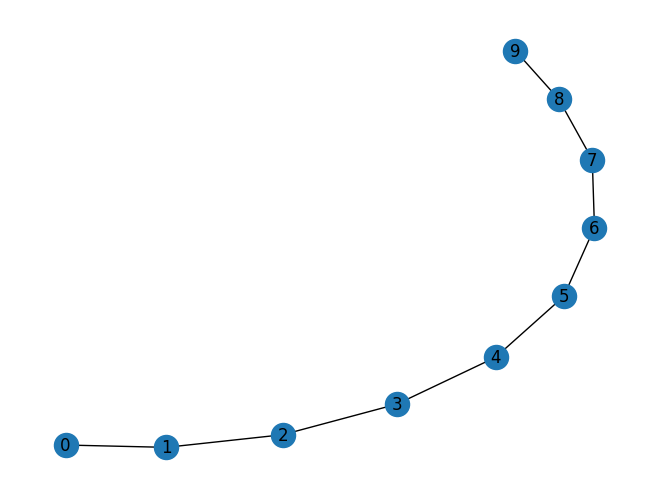

In [1]:
import networkx as nx

# Create a graph
L = 10
G = nx.Graph()
G.add_edges_from([(k,k+1) for k in range(L-1)]) 
nx.draw(G, with_labels=True)

## Define Heisenberg Hamiltonian and (rescaled) Hamiltonian evolution

In [2]:
from qrisp.operators import X, Y, Z

def create_heisenberg_hamiltonian(G):
    H = sum(X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) for (i,j) in G.edges())
    return H

H = create_heisenberg_hamiltonian(G)
print(H)

# Define scaling factor
F = 10

# Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps
def exp_H(qv, t):
    H.trotterization(method='commuting')(qv,t/F,5)

X(0)*X(1) + X(1)*X(2) + X(2)*X(3) + X(3)*X(4) + X(4)*X(5) + X(5)*X(6) + X(6)*X(7) + X(7)*X(8) + X(8)*X(9) + Y(0)*Y(1) + Y(1)*Y(2) + Y(2)*Y(3) + Y(3)*Y(4) + Y(4)*Y(5) + Y(5)*Y(6) + Y(6)*Y(7) + Y(7)*Y(8) + Y(8)*Y(9) + Z(0)*Z(1) + Z(1)*Z(2) + Z(2)*Z(3) + Z(3)*Z(4) + Z(4)*Z(5) + Z(5)*Z(6) + Z(6)*Z(7) + Z(7)*Z(8) + Z(8)*Z(9)


## Calculate eigenvalues clasically

In [3]:
import scipy
matrix = H.to_sparse_matrix()
scipy.sparse.linalg.eigs(matrix)

(array([-17.03214083+3.44761314e-17j, -15.72269436-4.07694302e-17j,
        -14.10817429-5.87491153e-17j, -15.72269436+2.77555758e-17j,
        -15.72269436-2.41909433e-17j, -14.10817429+3.72678400e-17j]),
 array([[-1.24136280e-18-7.66297108e-21j,  1.82535827e-20-2.11829380e-18j,
         -4.62331678e-21+8.95228203e-19j,  1.66912420e-19-7.22575255e-18j,
          1.93441316e-17-8.02080358e-19j, -2.78569535e-17+2.19798259e-17j],
        [-3.22008041e-18-2.07974501e-18j, -1.16251347e-17+7.45754704e-18j,
         -1.34530146e-17-4.16582335e-18j, -8.81158034e-18+2.69793173e-18j,
         -1.64294434e-17-1.23278796e-17j,  4.21350600e-17+1.97567357e-17j],
        [-8.01181965e-19-2.46421592e-18j, -4.91491989e-18+2.75179613e-18j,
         -1.19505429e-17-1.56966910e-18j, -3.21058232e-18+5.35336824e-19j,
         -8.41670304e-18-6.60082958e-18j,  4.16216992e-17+9.10972395e-18j],
        ...,
        [ 3.44172279e-18-8.90676273e-19j, -6.67553107e-18+6.09278542e-18j,
          3.09826669e-18+2.9

## Tensor product of singlet states warm start

In [4]:
from qrisp import QuantumVariable   
from qrisp.vqe.problems.heisenberg import create_heisenberg_init_function

M = nx.maximal_matching(G)
U_0 = create_heisenberg_init_function(M)

qv = QuantumVariable(L)
U_0(qv)
E_0 = H.get_measurement(qv,precision=0.01)
print(E_0)

-14.996085060948468                                                                  


## GC

In [5]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 4
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_GC = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='GC')
    qc = qv.qs.compile()
    circuits_GC.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-14.996085060948468, -16.38885687647868, -16.752371098060998, -16.904622375710364, -16.95675940989281]


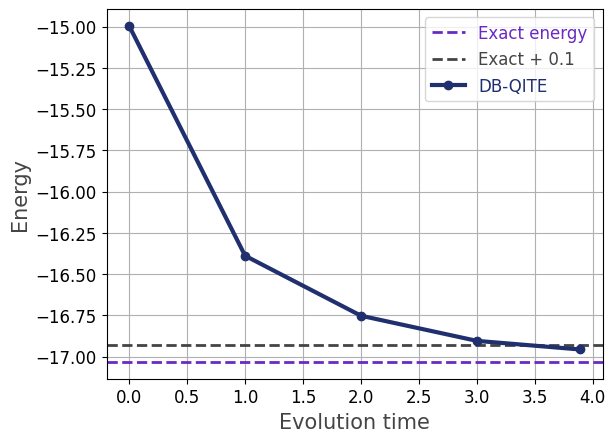

In [6]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## HOPF

In [7]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 3
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_HOPF = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='HOPF')
    qc = qv.qs.compile()
    circuits_HOPF.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-14.996085060948468, -16.5350595625192, -16.90103611005215, -16.979533831217147]    


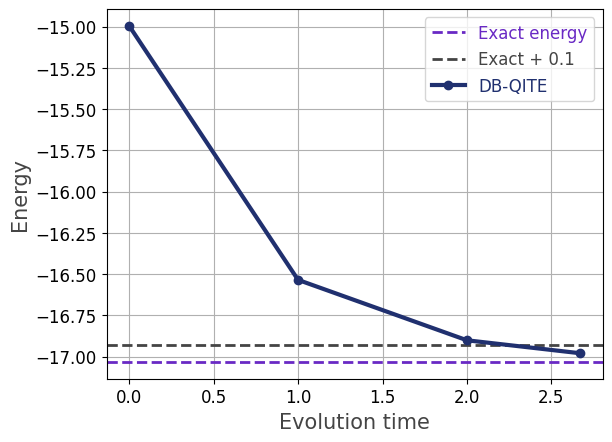

In [8]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## VQE warm start (1 layer)

* 1 layer of problem specific Ansatz: https://arxiv.org/abs/2108.08086, https://qrisp.eu/reference/Algorithms/vqe/vqeProblems/heisenberg.html

In [9]:
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *

vqe = heisenberg_problem(G,1,0)
U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=1,max_iter=50)

qv= QuantumVariable(G.number_of_nodes())
U_0(qv)
E_0 = H.get_measurement(qv,precision=0.01)
print(E_0)


-16.33962837737637                                                                   


## GC

In [10]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 4
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_VQE_GC = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='GC')
    qc = qv.qs.compile()

    circuits_VQE_GC.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-16.33962837737637, -16.864704242986495, -16.957982518563988, -16.992117664988463, -17.03160188555176]


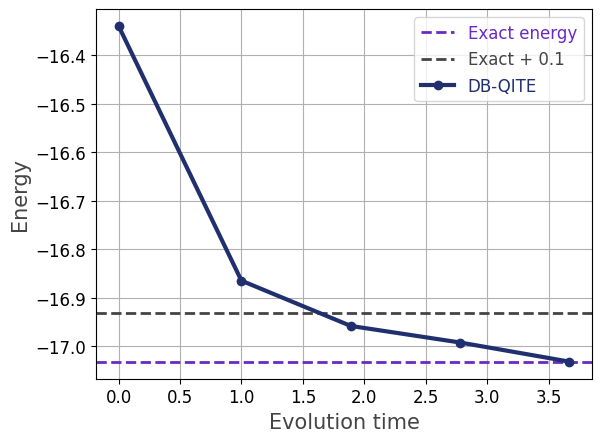

In [11]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## HOPF

In [12]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 3
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_VQE_HOPF = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='HOPF')
    qc = qv.qs.compile()
    circuits_VQE_HOPF.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-16.33962837737637, -16.884417734393445, -16.96681796678795, -17.015102517488202]   


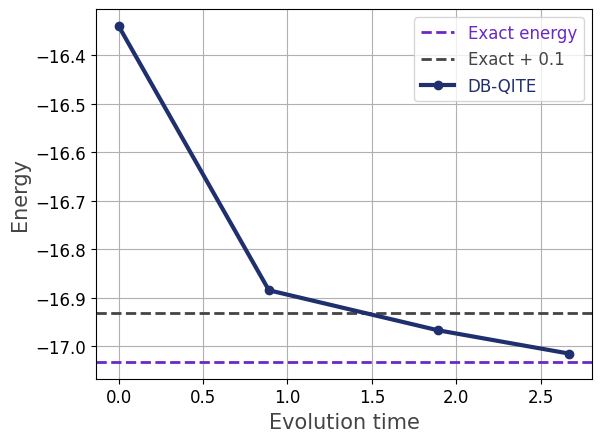

In [13]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## VQE warm start (2 layers)

* 2 layers of problem specific Ansatz: https://arxiv.org/abs/2108.08086, https://qrisp.eu/reference/Algorithms/vqe/vqeProblems/heisenberg.html

In [14]:
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *

vqe = heisenberg_problem(G,1,0)
U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=2,max_iter=50)

qv= QuantumVariable(G.number_of_nodes())
U_0(qv)
E_0 = H.get_measurement(qv,precision=0.01)
print(E_0)

-16.774016074977013                                                                  


## GC

In [15]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 4
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_VQE_2_GC = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='GC')
    qc = qv.qs.compile()

    circuits_VQE_2_GC.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-16.774016074977013, -16.93958360113808, -16.983430026522647, -17.00180404838263, -17.018264801177995]


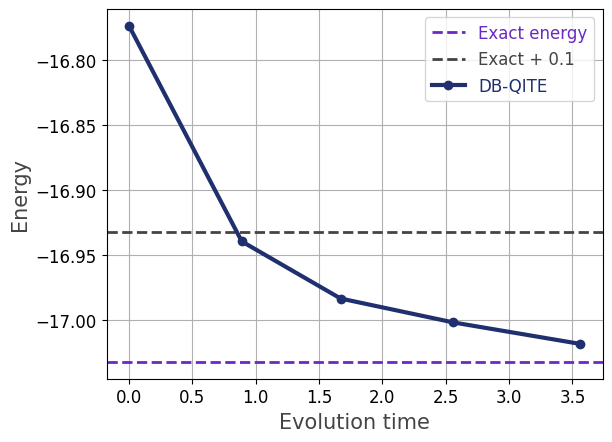

In [16]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## HOPF

In [17]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 2
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_VQE_2_HOPF = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='HOPF')
    qc = qv.qs.compile()
    circuits_VQE_2_HOPF.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-16.774016074977013, -16.962832814607438, -17.006949723553458]                      


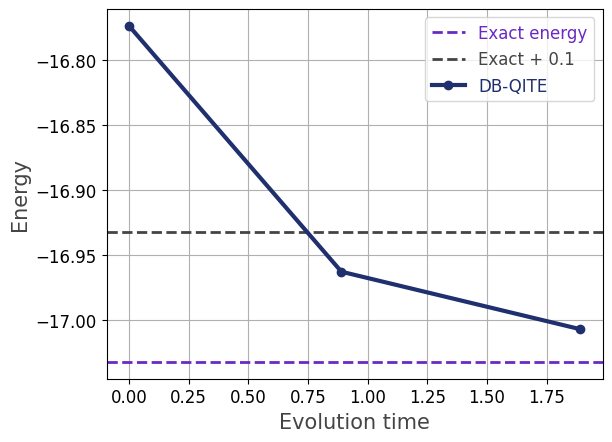

In [18]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## Example: extract information on quantum circuits

In [21]:
circuits_VQE_GC[1].count_ops()

{'x': 90,
 'p': 382,
 'cx': 1171,
 'h': 2273,
 'rz': 1162,
 'cz': 712,
 'uncompiled_gidney_mcx': 36,
 'uncompiled_gidney_mcx_inv': 36,
 'gphase': 1}

In [22]:
circuits_VQE_GC[1].transpile().count_ops()

{'x': 250,
 'p': 382,
 'cx': 1387,
 'h': 2273,
 'rz': 1162,
 'cz': 712,
 'sx': 72,
 't': 144,
 't_dg': 144,
 'sx_dg': 72,
 'gphase': 1}

VQE (1 layer) + GC (2 iterations)

In [23]:
# We need to bind the symbolic parameter theta to transpile to specific basis gates
qc = circuits_VQE_GC[1]
bqc = qc.bind_parameters(subs_dic={theta:1})
tqc = bqc.transpile(basis_gates=["cx","u"])

print(tqc.count_ops())
print(tqc.num_qubits())
print(tqc.depth())

{'u3': 3094, 'cx': 2001}
19
945


VQE (1 layer) + GC (4 iterations)

In [25]:
# We need to bind the symbolic parameter theta to transpile to specific basis gates
qc = circuits_VQE_GC[3]
bqc = qc.bind_parameters(subs_dic={theta:1})
tqc = bqc.transpile(basis_gates=["cx","u"])

print(tqc.count_ops())
print(tqc.num_qubits())
print(tqc.depth())

{'u3': 31270, 'cx': 20315}
19
9601
